# COX Proportional Hazards Model for Celiac Disease Outcome  
>
This notebook contains the code for generating supplementary figures 9 and 10.  

For the main analysis, tri-SNP dosage (0, 1 or 2) is fitted along with covariates: sex, having a first degree relative with CD diagnosis, genetic ancestry, HLA type, country, gluten intake and SNPS previously associated with the outcome.

In addition, the extended haplotype DR3-B8 is fitted instead of tri-SNP as a comparison to show the affect of tri-snp is stronger. 

The analyses are repeated using only DR3/DQ2 homozygotes.

This notebook is not heavily commented. Please see the code notebook for supplementary figures 1 and 2 for the comments and detailed explanation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from lifelines import CoxPHFitter
import pickle
import warnings
warnings.filterwarnings("ignore")
import session_info

session_info.show(html=False)

-----
lifelines           0.26.3
matplotlib          3.9.4
pandas              1.5.3
session_info        1.0.0
-----
IPython             8.18.1
jupyter_client      8.6.3
jupyter_core        5.8.1
jupyterlab          4.4.5
notebook            7.4.5
-----
Python 3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:27:35) [Clang 11.1.0 ]
macOS-15.6.1-x86_64-i386-64bit
-----
Session information updated at 2025-09-19 10:10


Import metadata

In [2]:
filtered = pd.read_csv("../data/filtered_meta_final.csv")
filtered.head()

,mp257_maskid,family_id,immunochip_id,sex,Cntry,POP,ancestry,POP_reported,t1d,t1d_diag_age_censor,...,rs61751041 (LAMB1),rs6967298 (AUTS2),rs72704176 (ASH1L),rs72717025 (FCGR2A),rs73043122 (RNASET2/MIR3939),rs77532435 (GRB10),rs8013918 (FOS),rs9934817 (RBFOX1),rs389884,rs926552
0,996512,9000247.0,9000247_996512,Male,SWE,EUR,EUR,NaN,1,135.972,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,474979,474979.0,474979_474979,Male,SWE,EUR,EUR,NaN,0,183.443,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2,581412,581412.0,581412_581412,Male,SWE,EUR,EUR,NaN,0,186.235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,864158,864158.0,864158_864158,Male,SWE,EUR,EUR,EUR,0,167.017,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,669152,669152.0,669152_669152,Male,SWE,EUR,EUR,NaN,0,174.080,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0


Create ordered hla type list

In [3]:
select_hla = ['DR4/DR8', 'DR3/DR3', 'DR3/DR4',
              'DR4/DR4', "DR1/DR4", "DR4/DR13"]
filtered["hla_type"] = pd.Categorical(filtered["hla_type"], 
               categories=select_hla,
               ordered=True)

Create oredered population list

In [4]:
select_pops = ["EUR", "AMR", "AFR"]
filtered["POP"] = pd.Categorical(
    filtered["POP"],
    categories=select_pops,
    ordered=True)

Create ordered country category

In [5]:
ctry = ["US", "SWE", "FIN", "GER"]
filtered["Country"] = pd.Categorical(
    filtered["Cntry"],
    categories=ctry,
    ordered=True)

Load previous GWAS covariates

In [6]:
snps = pd.read_table("../data/assoc_snps_220824.tsv")
snps.head()

,SNP,Locus,CD_SNP,tTGA_SNP,T1D_SNP,IAA_SNP,SNP_locus
0,rs4851575,"IL18R1, IL18RAP",1,0,0,0,"rs4851575 (IL18R1, IL18RAP)"
1,rs114569351,"PLEK,FBXO48",1,0,0,0,"rs114569351 (PLEK,FBXO48)"
2,rs12493471,"CCR9,LZTFL1,CXCR6",1,0,0,0,"rs12493471 (CCR9,LZTFL1,CXCR6)"
3,rs1054091,"RSPH3,TAGAP",1,0,0,0,"rs1054091 (RSPH3,TAGAP)"
4,rs72704176,ASH1L,1,0,0,0,rs72704176 (ASH1L)


In [7]:
t1d_snps = list(snps.loc[snps["T1D_SNP"] == 1, "SNP_locus"].values)
iaa_snps = list(snps.loc[snps["IAA_SNP"] == 1, "SNP_locus"].values)
tga_snps = list(snps.loc[snps["tTGA_SNP"] == 1, "SNP_locus"].values)
cd_snps = list(snps.loc[snps["CD_SNP"] == 1, "SNP_locus"].values)

## Run coxph model for celiac disease diagnosis

In [8]:
# rename columns to figure-friendly names
filtered.rename(columns={"celiac_fdr": "FDR-CD"}, inplace=True)
filtered.rename(columns={"excess_pre_tga_gluten": "gluten_intake"},
                inplace=True)

In [9]:
assoc = cd_snps
event = "Event = CD Diagnosis"
common_variables = ['sex', 'FDR-CD', 'POP', "hla_type", 
                    "Country", "gluten_intake"] + assoc


common_others = ["Male", 'FDR-CD', "gluten_intake"]

time, outcome = "celiac_diagnosis_censor", "celiac_diagnosis"
outcomes = [time, outcome]

### Fit trisnp
This creates supplementary figure 9

<lifelines.CoxPHFitter: fitted with 6530 total observations, 5922 right-censored observations>
             duration col = 'celiac_diagnosis_censor'
                event col = 'celiac_diagnosis'
          robust variance = True
      baseline estimation = breslow
   number of observations = 6530
number of events observed = 608
   partial log-likelihood = -4895.57
         time fit was run = 2025-09-19 14:10:17 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
tri-SNP 101                      0.28       1.32       0.11             0.05             0.50                 1.06                 1.64
FDR-CD                           1.25       3.47       0.11             1.02             1.47                 2.79                 4.33
gluten_intake                    0.10       1.10       0.03             0.04             0.15                 1.04                 1.17
rs4851575 (IL18R1, IL18RAP)      0.17       1.19       0.07             0.04             0.31                 1.04                 1.36
rs114569351 (PLEK,FBXO48)        0.68       1.98       0.21             0.27             1.10                 1.30                 3.01
rs12493471 (CCR9,LZTFL1,CXCR6)   0.24       1.27       0.06             0.13             0.35                 1.14                 1.43
rs1054091 (RSPH3,TAGAP)          0.27       1.31       0.08             0.12             0.42                 1.13                 1.52
rs72704176 (ASH1L)               0.40       1.49       0.17             0.07             0.73                 1.07                 2.07
rs3771689 (BAZ2B)               -0.30       0.74       0.09            -0.47            -0.12                 0.62                 0.89
rs13014907 (ZNF804A)             0.42       1.51       0.20             0.02             0.81                 1.02                 2.25
rs11739460 (TCOF1)               0.12       1.13       0.06             0.01             0.23                 1.01                 1.26
rs77532435 (GRB10)               0.41       1.51       0.14             0.13             0.69                 1.14                 2.00
rs6967298 (AUTS2)               -0.21       0.81       0.08            -0.37            -0.05                 0.69                 0.95
rs61751041 (LAMB1)               0.33       1.39       0.17            -0.01             0.67                 0.99                 1.96
rs2409747 (XKR6)                 0.21       1.23       0.08             0.04             0.37                 1.05                 1.45
Male                            -0.59       0.56       0.09            -0.76            -0.41                 0.47                 0.66
AMR                             -0.48       0.62       0.24            -0.95            -0.01                 0.39                 0.99
AFR                             -1.16       0.31       1.02            -3.16             0.85                 0.04                 2.35
DR3/DR3                          2.43      11.41       0.36             1.73             3.14                 5.65                23.07
DR3/DR4                          1.60       4.94       0.32             0.98             2.22                 2.66                 9.19
DR4/DR4                          1.66       5.27       0.31             1.05             2.27                 2.86                 9.71
DR1/DR4                          0.83       2.30       0.59            -0.32             1.99                 0.72                 7.30
DR4/DR13                         1.60       4.97       0.62             0.39             2.82                 1.48                16.71
SWE                              0.14       1.15       0.10            -0.06             0.34                 0.94                 1.40
FIN                             -0.10   

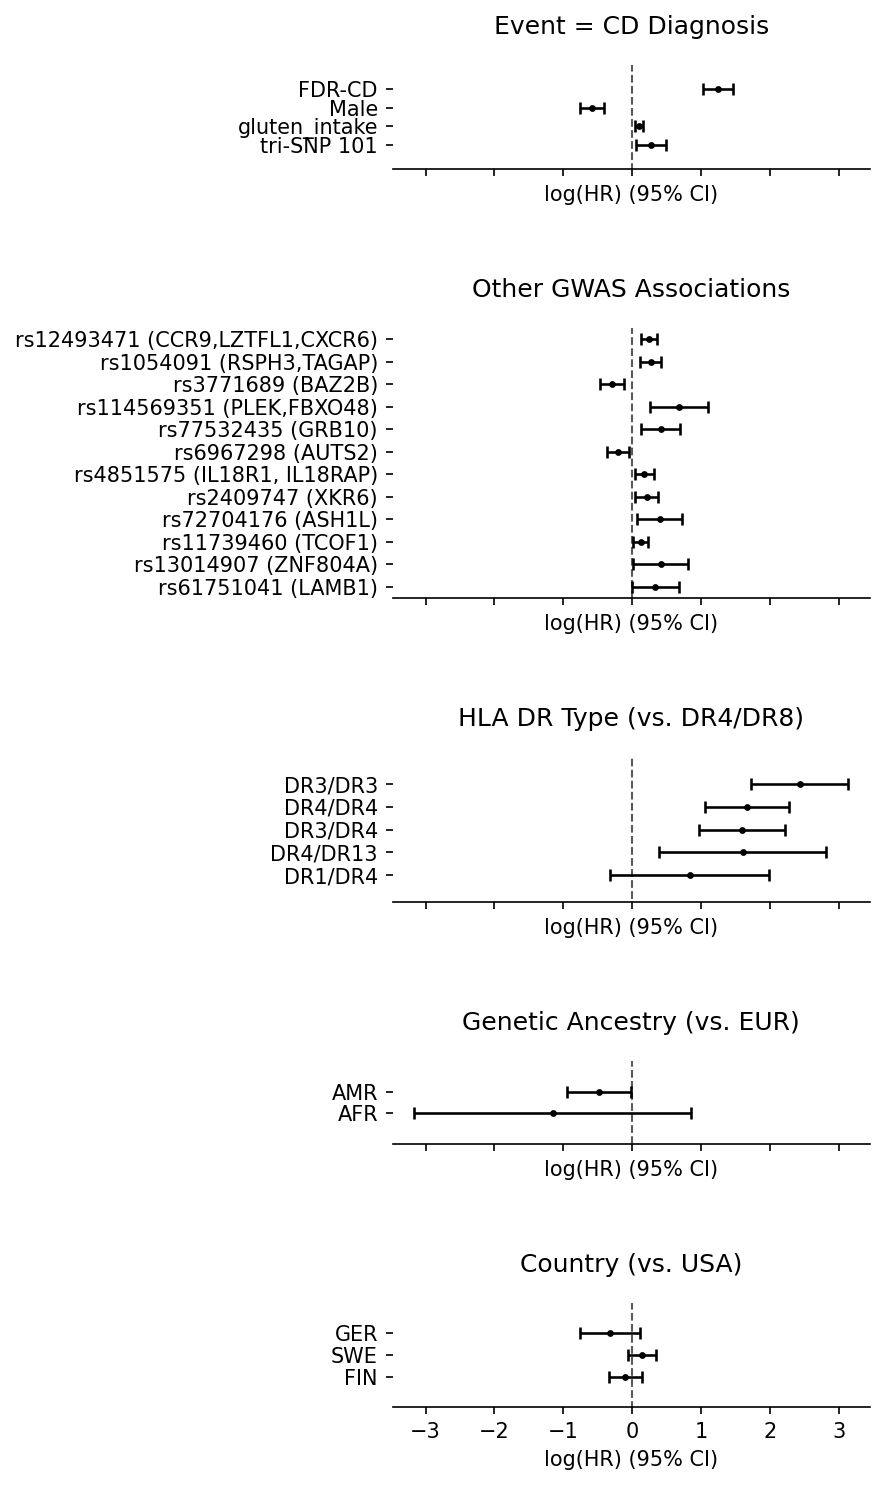

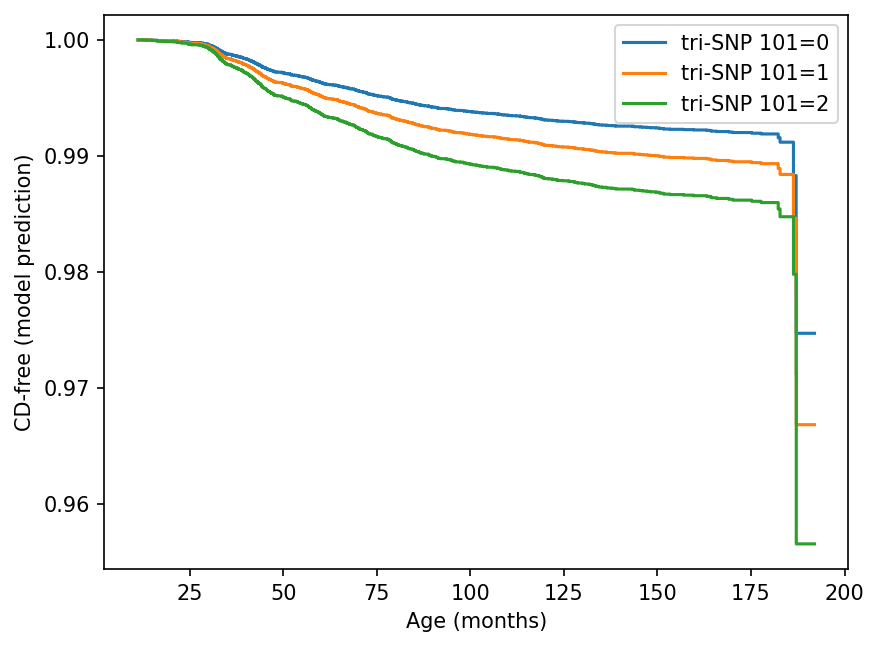

In [10]:
fit_var = "tri-SNP 101"

extension = "cox_cd_all_samples"
ylabel = "CD-free (model prediction)"

variables = [fit_var] + common_variables
data = filtered.loc[:, variables + outcomes].dropna()
dummy = pd.get_dummies(data, drop_first=True, prefix="", prefix_sep="")
cph = CoxPHFitter()
cph.fit(dummy, time, event_col=outcome, robust=True)
cph.print_summary()

summary = cph.summary.reset_index()
summary.to_csv(extension + "_summary.csv")

others = [fit_var] + common_others

covar_list = [others, assoc, select_hla, select_pops, ctry]
titles = [event, "Other GWAS Associations",
          "HLA DR Type (vs. DR4/DR8)", 
          "Genetic Ancestry (vs. EUR)",
          "Country (vs. USA)"]
fig, axes = plt.subplots(
    len(covar_list), 1, sharex=True, gridspec_kw={
        'height_ratios': [len(cov) + 1 for cov in covar_list]})

for i in range(len(covar_list)):
    ax = axes[i]
    covars = list(summary.loc[summary["covariate"].isin(
        covar_list[i])].sort_values("p")["covariate"].values)
    cph.plot(ax=ax, columns=covars, hazard_ratios=False, ms=2, fmt="o", markerfacecolor="k")
    ax.set_title(titles[i], pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.autoscale(True, axis="y")
    ax.margins(y=-0.1)

fig.set_dpi(150)
fig.set_size_inches(6, 2 * len(covar_list))
fig.tight_layout(h_pad=3.5)
fig.savefig(extension + ".pdf")
fig.savefig(extension + ".png", facecolor="w")

fig, ax = plt.subplots()
cph.plot_partial_effects_on_outcome(covariates=fit_var, values=[0,1,2], 
                                    plot_baseline=False, ax=ax)
ax.set_xlabel("Age (months)")
ax.set_ylabel(ylabel)
fig.set_dpi(150)
fig.savefig(extension + "_effect_on_outcome.pdf")
fig.savefig(extension + "_effect_on_outcome.png", facecolor="w")

with open(extension + "_cph.pickle", "wb") as outfile:
    pickle.dump(cph, outfile)

### Fit B8 for all samples

<lifelines.CoxPHFitter: fitted with 6530 total observations, 5922 right-censored observations>
             duration col = 'celiac_diagnosis_censor'
                event col = 'celiac_diagnosis'
          robust variance = True
      baseline estimation = breslow
   number of observations = 6530
number of events observed = 608
   partial log-likelihood = -4897.39
         time fit was run = 2025-09-19 14:10:23 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
B8                               0.11       1.11       0.07            -0.03             0.25                 0.97                 1.28
FDR-CD                           1.25       3.49       0.11             1.03             1.47                 2.81                 4.35
gluten_intake                    0.10       1.10       0.03             0.04             0.15                 1.04                 1.17
rs4851575 (IL18R1, IL18RAP)      0.17       1.18       0.07             0.03             0.30                 1.03                 1.35
rs114569351 (PLEK,FBXO48)        0.67       1.96       0.21             0.25             1.09                 1.29                 2.99
rs12493471 (CCR9,LZTFL1,CXCR6)   0.25       1.28       0.06             0.13             0.36                 1.14                 1.43
rs1054091 (RSPH3,TAGAP)          0.27       1.31       0.08             0.12             0.42                 1.13                 1.52
rs72704176 (ASH1L)               0.40       1.49       0.17             0.07             0.73                 1.07                 2.07
rs3771689 (BAZ2B)               -0.30       0.74       0.09            -0.47            -0.12                 0.62                 0.89
rs13014907 (ZNF804A)             0.40       1.50       0.21            -0.00             0.81                 1.00                 2.24
rs11739460 (TCOF1)               0.12       1.13       0.06             0.01             0.23                 1.01                 1.26
rs77532435 (GRB10)               0.42       1.52       0.14             0.14             0.70                 1.15                 2.01
rs6967298 (AUTS2)               -0.22       0.81       0.08            -0.38            -0.06                 0.69                 0.95
rs61751041 (LAMB1)               0.32       1.38       0.17            -0.02             0.66                 0.98                 1.93
rs2409747 (XKR6)                 0.20       1.22       0.08             0.04             0.36                 1.04                 1.43
Male                            -0.59       0.56       0.09            -0.76            -0.42                 0.47                 0.66
AMR                             -0.53       0.59       0.24            -0.99            -0.07                 0.37                 0.94
AFR                             -1.32       0.27       1.02            -3.33             0.68                 0.04                 1.97
DR3/DR3                          2.78      16.11       0.31             2.16             3.40                 8.70                29.86
DR3/DR4                          1.77       5.90       0.30             1.18             2.37                 3.25                10.71
DR4/DR4                          1.67       5.29       0.31             1.06             2.28                 2.87                 9.76
DR1/DR4                          0.83       2.30       0.59            -0.32             1.99                 0.72                 7.30
DR4/DR13                         1.61       5.01       0.62             0.40             2.82                 1.49                16.85
SWE                              0.14       1.15       0.10            -0.05             0.34                 0.95                 1.41
FIN                             -0.09   

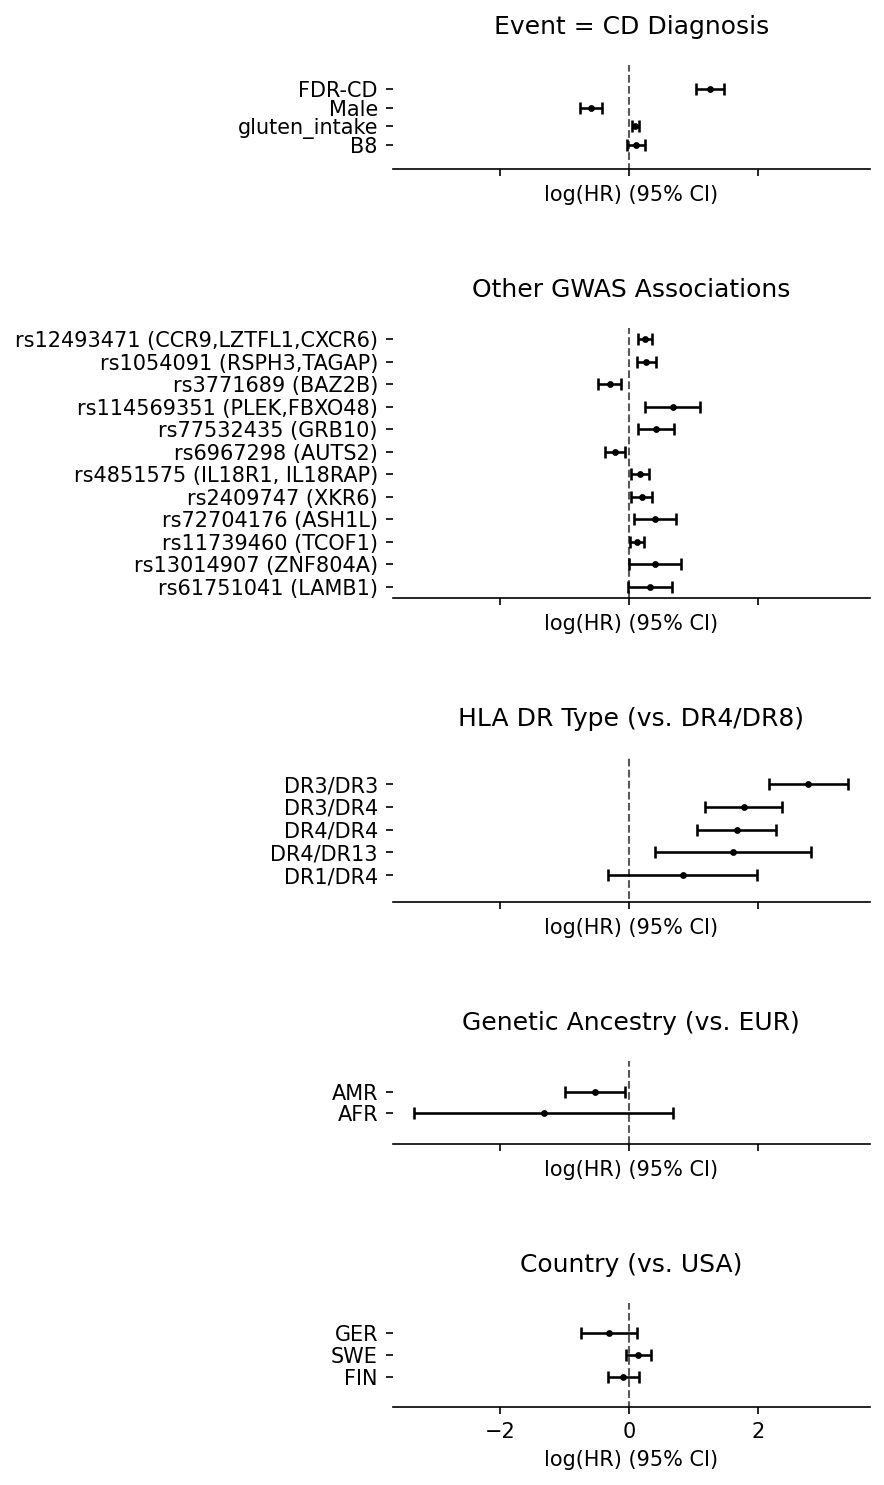

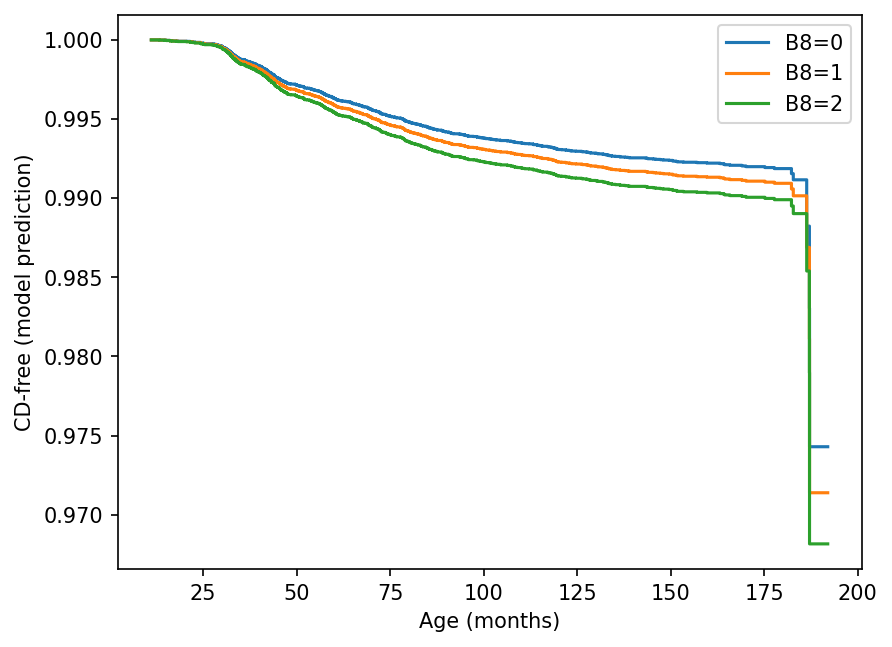

In [11]:
fit_var = "B8"

extension = "cox_cd_all_samples_b8"
ylabel = "CD-free (model prediction)"

variables = [fit_var] + common_variables
data = filtered.loc[:, variables + outcomes].dropna()
dummy = pd.get_dummies(data, drop_first=True, prefix="", prefix_sep="")
cph = CoxPHFitter()
cph.fit(dummy, time, event_col=outcome, robust=True)
cph.print_summary()

summary = cph.summary.reset_index()
summary.to_csv(extension + "_summary.csv")

others = [fit_var] + common_others

covar_list = [others, assoc, select_hla, select_pops, ctry]
titles = [event, "Other GWAS Associations",
          "HLA DR Type (vs. DR4/DR8)", 
          "Genetic Ancestry (vs. EUR)",
          "Country (vs. USA)"]
fig, axes = plt.subplots(
    len(covar_list), 1, sharex=True, gridspec_kw={
        'height_ratios': [len(cov) + 1 for cov in covar_list]})

for i in range(len(covar_list)):
    ax = axes[i]
    covars = list(summary.loc[summary["covariate"].isin(
        covar_list[i])].sort_values("p")["covariate"].values)
    cph.plot(ax=ax, columns=covars, hazard_ratios=False, ms=2, fmt="o", markerfacecolor="k")
    ax.set_title(titles[i], pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.autoscale(True, axis="y")
    ax.margins(y=-0.1)

fig.set_dpi(150)
fig.set_size_inches(6, 2 * len(covar_list))
fig.tight_layout(h_pad=3.5)
fig.savefig(extension + ".pdf")
fig.savefig(extension + ".png", facecolor="w")

fig, ax = plt.subplots()
cph.plot_partial_effects_on_outcome(covariates=fit_var, values=[0,1,2], 
                                    plot_baseline=False, ax=ax)
ax.set_xlabel("Age (months)")
ax.set_ylabel(ylabel)
fig.set_dpi(150)
fig.savefig(extension + "_effect_on_outcome.pdf")
fig.savefig(extension + "_effect_on_outcome.png", facecolor="w")

with open(extension + "_cph.pickle", "wb") as outfile:
    pickle.dump(cph, outfile)

### DR3 homozygotes only

In [12]:
event = "Event = CD Diagnosis, DR3 Only"

common_variables = ['sex', 'FDR-CD', 'POP', 
                    "Country", "gluten_intake"] + assoc

### Fit trisnp
This creates supplementary figure 10.

<lifelines.CoxPHFitter: fitted with 1364 total observations, 1066 right-censored observations>
             duration col = 'celiac_diagnosis_censor'
                event col = 'celiac_diagnosis'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1364
number of events observed = 298
   partial log-likelihood = -1998.43
         time fit was run = 2025-09-19 14:10:28 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
tri-SNP 101                      0.28       1.32       0.13             0.02             0.53                 1.02                 1.70
FDR-CD                           1.04       2.82       0.15             0.74             1.34                 2.09                 3.81
gluten_intake                    0.12       1.12       0.05             0.03             0.20                 1.03                 1.23
rs4851575 (IL18R1, IL18RAP)      0.25       1.28       0.10             0.05             0.44                 1.05                 1.56
rs114569351 (PLEK,FBXO48)        0.08       1.08       0.41            -0.73             0.89                 0.48                 2.43
rs12493471 (CCR9,LZTFL1,CXCR6)   0.31       1.37       0.08             0.15             0.48                 1.16                 1.61
rs1054091 (RSPH3,TAGAP)          0.11       1.12       0.12            -0.12             0.34                 0.89                 1.41
rs72704176 (ASH1L)               0.43       1.54       0.24            -0.04             0.90                 0.96                 2.45
rs3771689 (BAZ2B)               -0.34       0.71       0.13            -0.60            -0.09                 0.55                 0.92
rs13014907 (ZNF804A)             0.65       1.92       0.27             0.13             1.17                 1.14                 3.23
rs11739460 (TCOF1)               0.11       1.11       0.08            -0.06             0.27                 0.94                 1.32
rs77532435 (GRB10)               0.31       1.37       0.20            -0.08             0.70                 0.92                 2.02
rs6967298 (AUTS2)               -0.32       0.73       0.13            -0.57            -0.07                 0.57                 0.94
rs61751041 (LAMB1)               0.55       1.74       0.24             0.08             1.03                 1.08                 2.80
rs2409747 (XKR6)                 0.24       1.27       0.12             0.00             0.48                 1.00                 1.61
Male                            -0.70       0.50       0.12            -0.94            -0.46                 0.39                 0.63
AMR                             -0.59       0.55       0.42            -1.41             0.23                 0.24                 1.26
AFR                             -0.46       0.63       1.07            -2.56             1.65                 0.08                 5.18
SWE                              0.16       1.17       0.15            -0.13             0.45                 0.88                 1.56
FIN                              0.06       1.06       0.17            -0.27             0.39                 0.76                 1.47
GER                             -0.27       0.76       0.33            -0.92             0.38                 0.40                 1.47

                                   z      p   -log2(p)
covariate                                             
tri-SNP 101                     2.09   0.04       4.78
FDR-CD                          6.75 <0.005      36.01
gluten_intake                   2.55   0.01       6.56
rs4851575 (IL18R1, IL18RAP)     2.49   0.01       6.31
rs114569351 (PLEK,FBXO48)       0.19   0.85       0.24
rs12493471 (CCR9,LZTFL1,CXCR6)  3.72 <0.005      12.28
rs10540

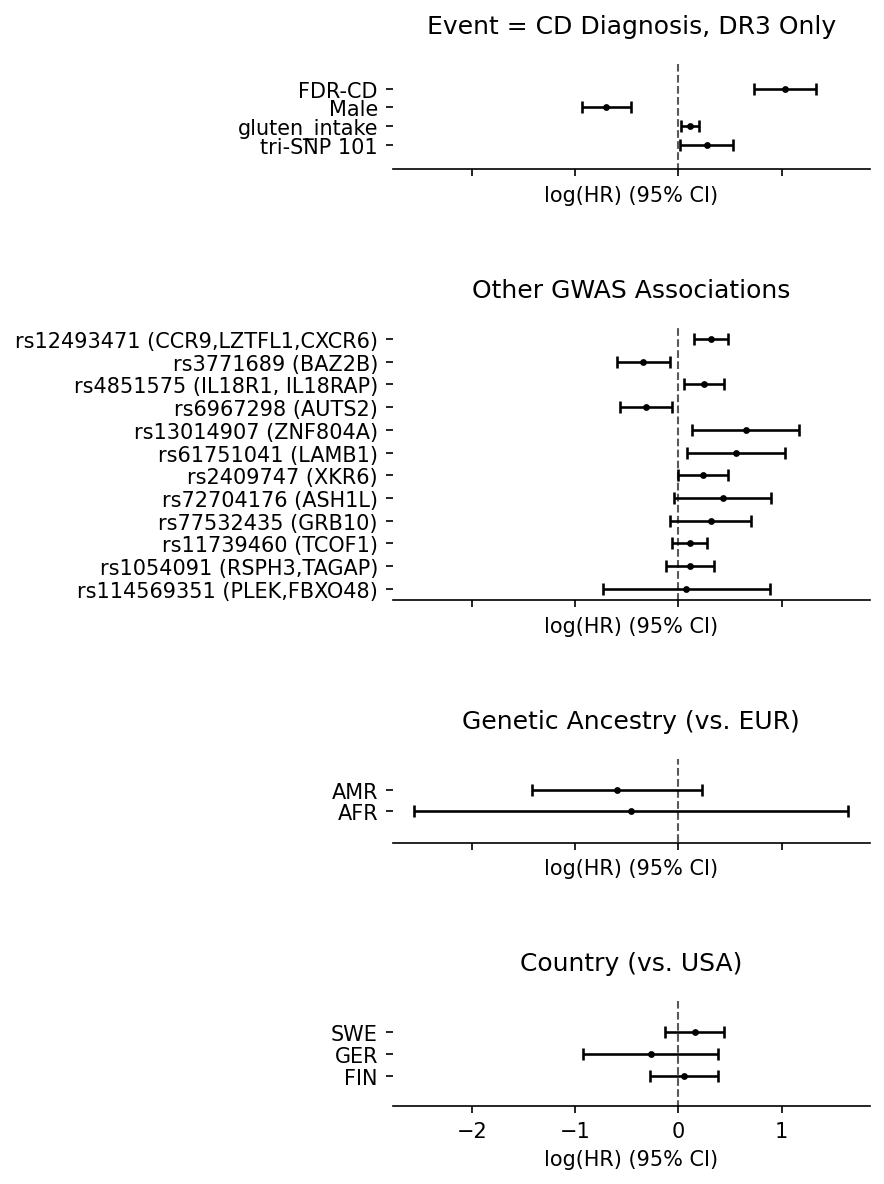

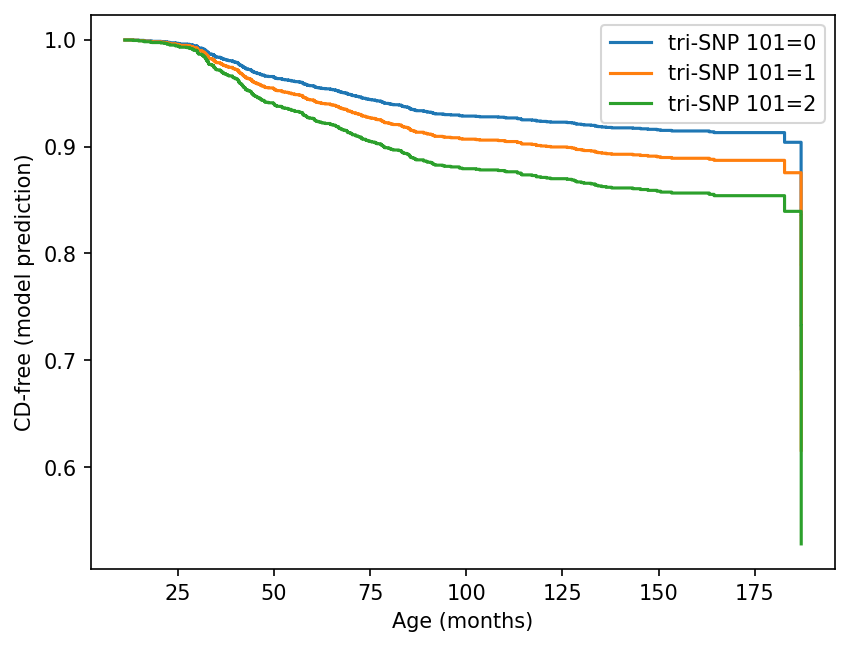

In [13]:
fit_var = "tri-SNP 101"

extension = "cox_cd_dr3_samples"
ylabel = "CD-free (model prediction)"

variables = [fit_var] + common_variables

data = filtered.loc[filtered["hla_type"] == "DR3/DR3",
                    variables + outcomes].dropna()

dummy = pd.get_dummies(data, drop_first=True, prefix="", prefix_sep="")
cph = CoxPHFitter()
cph.fit(dummy, time, event_col=outcome, robust=True)
cph.print_summary()

summary = cph.summary.reset_index()
summary.to_csv(extension + "_summary.csv")

others = [fit_var] + common_others

covar_list = [others, assoc, select_pops, ctry]
titles = [event, "Other GWAS Associations",
          "Genetic Ancestry (vs. EUR)",
          "Country (vs. USA)"]
fig, axes = plt.subplots(
    len(covar_list), 1, sharex=True, gridspec_kw={
        'height_ratios': [len(cov) + 1 for cov in covar_list]})

for i in range(len(covar_list)):
    ax = axes[i]
    covars = list(summary.loc[summary["covariate"].isin(
        covar_list[i])].sort_values("p")["covariate"].values)
    cph.plot(ax=ax, columns=covars, hazard_ratios=False, ms=2, fmt="o", markerfacecolor="k")
    ax.set_title(titles[i], pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.autoscale(True, axis="y")
    ax.margins(y=-0.1)

fig.set_dpi(150)
fig.set_size_inches(6, 2 * len(covar_list))
fig.tight_layout(h_pad=3.5)
fig.savefig(extension + ".pdf")
fig.savefig(extension + ".png", facecolor="w")

fig, ax = plt.subplots()
cph.plot_partial_effects_on_outcome(covariates=fit_var, values=[0,1,2], 
                                    plot_baseline=False, ax=ax)
ax.set_xlabel("Age (months)")
ax.set_ylabel(ylabel)
fig.set_dpi(150)
fig.savefig(extension + "_effect_on_outcome.pdf")
fig.savefig(extension + "_effect_on_outcome.png", facecolor="w")

with open(extension + "_cph.pickle", "wb") as outfile:
    pickle.dump(cph, outfile)

### Fit B8 for DR3 homozygotes only

<lifelines.CoxPHFitter: fitted with 1364 total observations, 1066 right-censored observations>
             duration col = 'celiac_diagnosis_censor'
                event col = 'celiac_diagnosis'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1364
number of events observed = 298
   partial log-likelihood = -2000.06
         time fit was run = 2025-09-19 14:10:29 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
B8                               0.09       1.09       0.08            -0.07             0.25                 0.93                 1.28
FDR-CD                           1.04       2.84       0.15             0.75             1.34                 2.11                 3.83
gluten_intake                    0.12       1.12       0.04             0.03             0.21                 1.03                 1.23
rs4851575 (IL18R1, IL18RAP)      0.23       1.26       0.10             0.04             0.43                 1.04                 1.53
rs114569351 (PLEK,FBXO48)        0.06       1.06       0.42            -0.77             0.89                 0.46                 2.44
rs12493471 (CCR9,LZTFL1,CXCR6)   0.32       1.37       0.08             0.15             0.48                 1.17                 1.62
rs1054091 (RSPH3,TAGAP)          0.11       1.12       0.12            -0.12             0.35                 0.89                 1.41
rs72704176 (ASH1L)               0.42       1.53       0.24            -0.05             0.89                 0.95                 2.45
rs3771689 (BAZ2B)               -0.34       0.71       0.13            -0.59            -0.09                 0.55                 0.92
rs13014907 (ZNF804A)             0.64       1.90       0.27             0.10             1.18                 1.11                 3.24
rs11739460 (TCOF1)               0.11       1.12       0.09            -0.05             0.28                 0.95                 1.32
rs77532435 (GRB10)               0.32       1.38       0.20            -0.07             0.71                 0.93                 2.03
rs6967298 (AUTS2)               -0.33       0.72       0.13            -0.58            -0.08                 0.56                 0.92
rs61751041 (LAMB1)               0.54       1.72       0.24             0.07             1.01                 1.08                 2.75
rs2409747 (XKR6)                 0.22       1.25       0.12            -0.01             0.46                 0.99                 1.58
Male                            -0.70       0.50       0.12            -0.94            -0.46                 0.39                 0.63
AMR                             -0.70       0.49       0.42            -1.52             0.11                 0.22                 1.12
AFR                             -0.70       0.50       1.06            -2.77             1.37                 0.06                 3.94
SWE                              0.17       1.18       0.14            -0.12             0.45                 0.89                 1.57
FIN                              0.08       1.09       0.17            -0.25             0.41                 0.78                 1.51
GER                             -0.26       0.77       0.33            -0.91             0.40                 0.40                 1.49

                                   z      p   -log2(p)
covariate                                             
B8                              1.06   0.29       1.79
FDR-CD                          6.87 <0.005      37.21
gluten_intake                   2.61   0.01       6.78
rs4851575 (IL18R1, IL18RAP)     2.35   0.02       5.72
rs114569351 (PLEK,FBXO48)       0.14   0.89       0.17
rs12493471 (CCR9,LZTFL1,CXCR6)  3.79 <0.005      12.71
rs10540

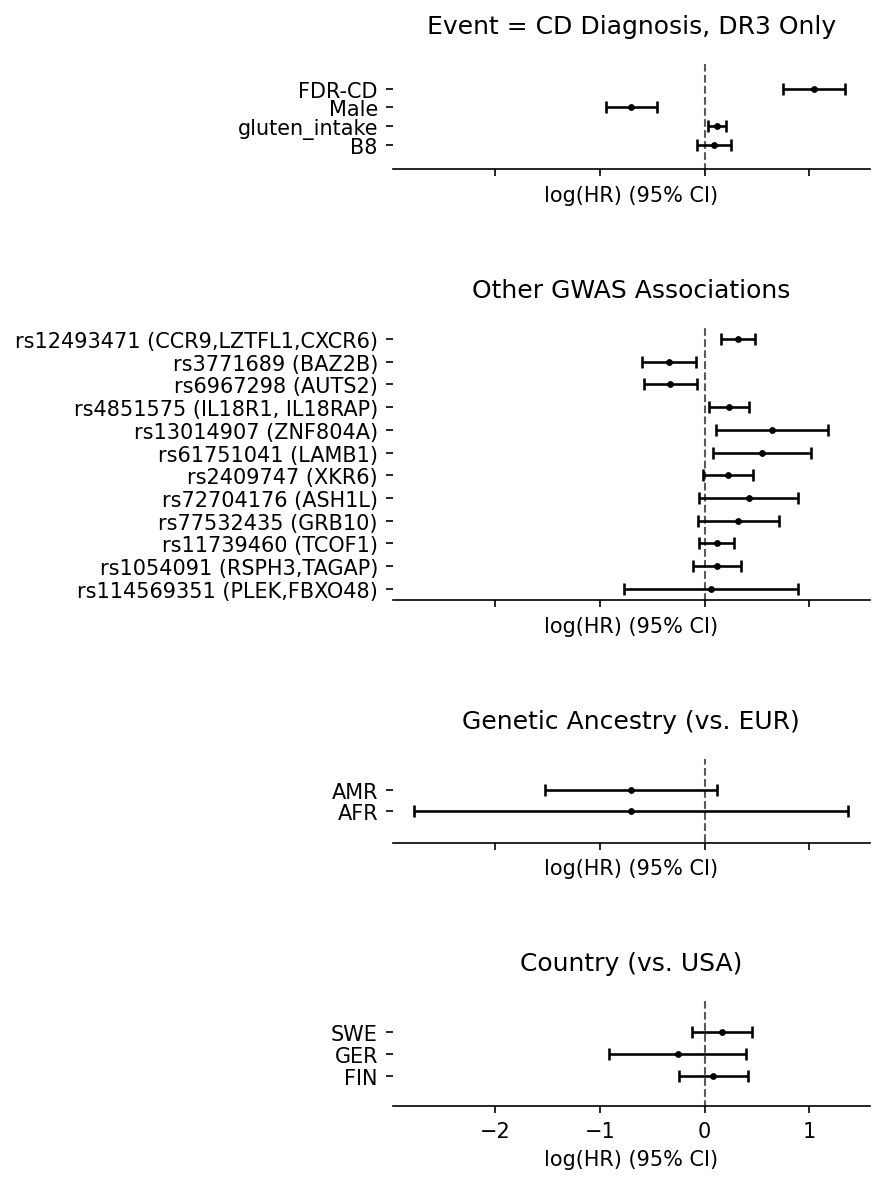

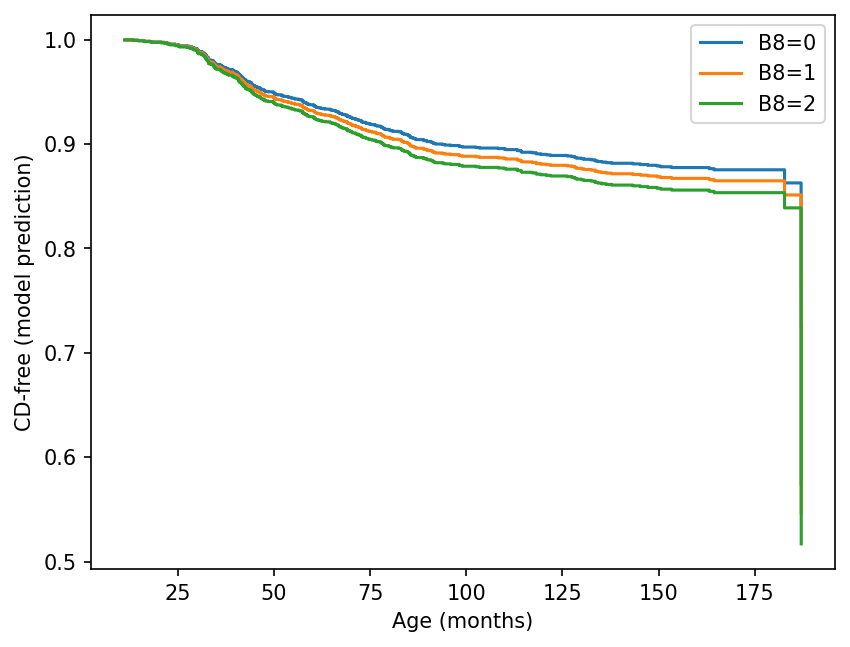

In [14]:
fit_var = "B8"

extension = "cox_cd_dr3_samples_b8"
ylabel = "CD-free (model prediction)"

variables = [fit_var] + common_variables

data = filtered.loc[filtered["hla_type"] == "DR3/DR3",
                    variables + outcomes].dropna()

dummy = pd.get_dummies(data, drop_first=True, prefix="", prefix_sep="")
cph = CoxPHFitter()
cph.fit(dummy, time, event_col=outcome, robust=True)
cph.print_summary()

summary = cph.summary.reset_index()
summary.to_csv(extension + "_summary.csv")

others = [fit_var] + common_others

covar_list = [others, assoc, select_pops, ctry]
titles = [event, "Other GWAS Associations",
          "Genetic Ancestry (vs. EUR)",
          "Country (vs. USA)"]
fig, axes = plt.subplots(
    len(covar_list), 1, sharex=True, gridspec_kw={
        'height_ratios': [len(cov) + 1 for cov in covar_list]})

for i in range(len(covar_list)):
    ax = axes[i]
    covars = list(summary.loc[summary["covariate"].isin(
        covar_list[i])].sort_values("p")["covariate"].values)
    cph.plot(ax=ax, columns=covars, hazard_ratios=False, ms=2, fmt="o", markerfacecolor="k")
    ax.set_title(titles[i], pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.autoscale(True, axis="y")
    ax.margins(y=-0.1)

fig.set_dpi(150)
fig.set_size_inches(6, 2 * len(covar_list))
fig.tight_layout(h_pad=3.5)
fig.savefig(extension + ".pdf")
fig.savefig(extension + ".png", facecolor="w")

fig, ax = plt.subplots()
cph.plot_partial_effects_on_outcome(covariates=fit_var, values=[0,1,2], 
                                    plot_baseline=False, ax=ax)
ax.set_xlabel("Age (months)")
ax.set_ylabel(ylabel)
fig.set_dpi(150)
fig.savefig(extension + "_effect_on_outcome.pdf")
fig.savefig(extension + "_effect_on_outcome.png", facecolor="w")

with open(extension + "_cph.pickle", "wb") as outfile:
    pickle.dump(cph, outfile)